In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision

import datasets, models, utils, training

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')

# Experiment 1: Image Classification

## Load EMNIST data and make a noisy variant

In [7]:
def run_image_classification_experiment(params, name=None, history=None):
    # Load datasets.
    train_dataset, val_dataset, test_dataset = datasets.load_emnist(seed=0)
    noisy_test_dataset = datasets.load_noisy_emnist(scaling_factor=params['scaling_factor'])
    
    # Wrap datasets in loaders.
    kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size_eval'], shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size_eval'], 
                                              shuffle=False, **kwargs)
    noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], 
                                                    shuffle=False, **kwargs)
    
    # Load model and optimizer.
    model = models.FeedforwardNet(num_hidden=500).to(device)
    #model = models.FeedbackNet(num_passes=params['num_passes']).to(device)
    print('Model has', utils.count_parameters(model), 'trainable parameters')
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

    # Train and test. 
    for epoch in range(params['num_epochs']):
        print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
        start_time = time.time()
        training.train(model, device, train_loader, optimizer, epoch+1)
        print('Took', time.time()-start_time, 'seconds')
        print()
        
        print('Validation set:')
        val_loss, val_acc = training.test(model, device, val_loader)
        print('Test set:')
        test_loss, test_acc = training.test(model, device, test_loader)
        print('Noisy test set:')
        noisy_test_loss, noisy_test_acc = training.test(model, device, noisy_test_loader)
        
        if history:
            history.log('val_loss', val_loss)
            history.log('val_acc', val_acc)
            history.log('test_loss', test_loss)
            history.log('test_acc', test_acc)
            history.log('noisy_test_loss', noisy_test_loss)
            history.log('noisy_test_acc', noisy_test_acc)

In [10]:
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5, scaling_factor=2, num_passes=2)
run_image_classification_experiment(params)

Model has 798310 trainable parameters
Epoch 1/30
Train Epoch: 1 [0/114800 (0%)]	Loss: 3.272624	Accuracy: 3.1%
Train Epoch: 1 [12800/114800 (11%)]	Loss: 1.939981	Accuracy: 53.1%


KeyboardInterrupt: 

## Hyperopt

In [28]:
log_dir = 'logs/0'

param_grid = {'batch_size': [64, 128],
              'batch_size_eval': [1000], 
              'num_epochs': [30], 
              'learning_rate': [0.005, 0.01, 0.02, 0.04], 
              'momentum': [0.3, 0.5, 0.7], 
              'scaling_factor': [2]}#, 
              #'num_passes': [2]}

grid_search = utils.GridSearch(log_dir, param_grid)
grid_search

GridSearch with 24 jobs:
{'index': 0, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.3, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 1, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.5, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 2, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.7, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 3, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.01, 'momentum': 0.3, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 4, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.01, 'momentum': 0.5, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 5, 'params': {'batch_size':

In [29]:
grid_search.run(run_image_classification_experiment)

Starting hyperparameter optimization (logging to logs/0)
Starting run 0 with parameters {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.3, 'num_epochs': 30, 'scaling_factor': 2}
Model has 656026 trainable parameters
Epoch 1/30
Train Epoch: 1 [0/114800 (0%)]	Loss: 6.237895	Accuracy: 0.0%
Train Epoch: 1 [12800/114800 (11%)]	Loss: 3.224815	Accuracy: 12.5%
Train Epoch: 1 [25600/114800 (22%)]	Loss: 2.319773	Accuracy: 31.2%
Train Epoch: 1 [38400/114800 (33%)]	Loss: 2.043557	Accuracy: 34.4%


KeyboardInterrupt: 

['logs/0/0.json', 'logs/0/1.json']


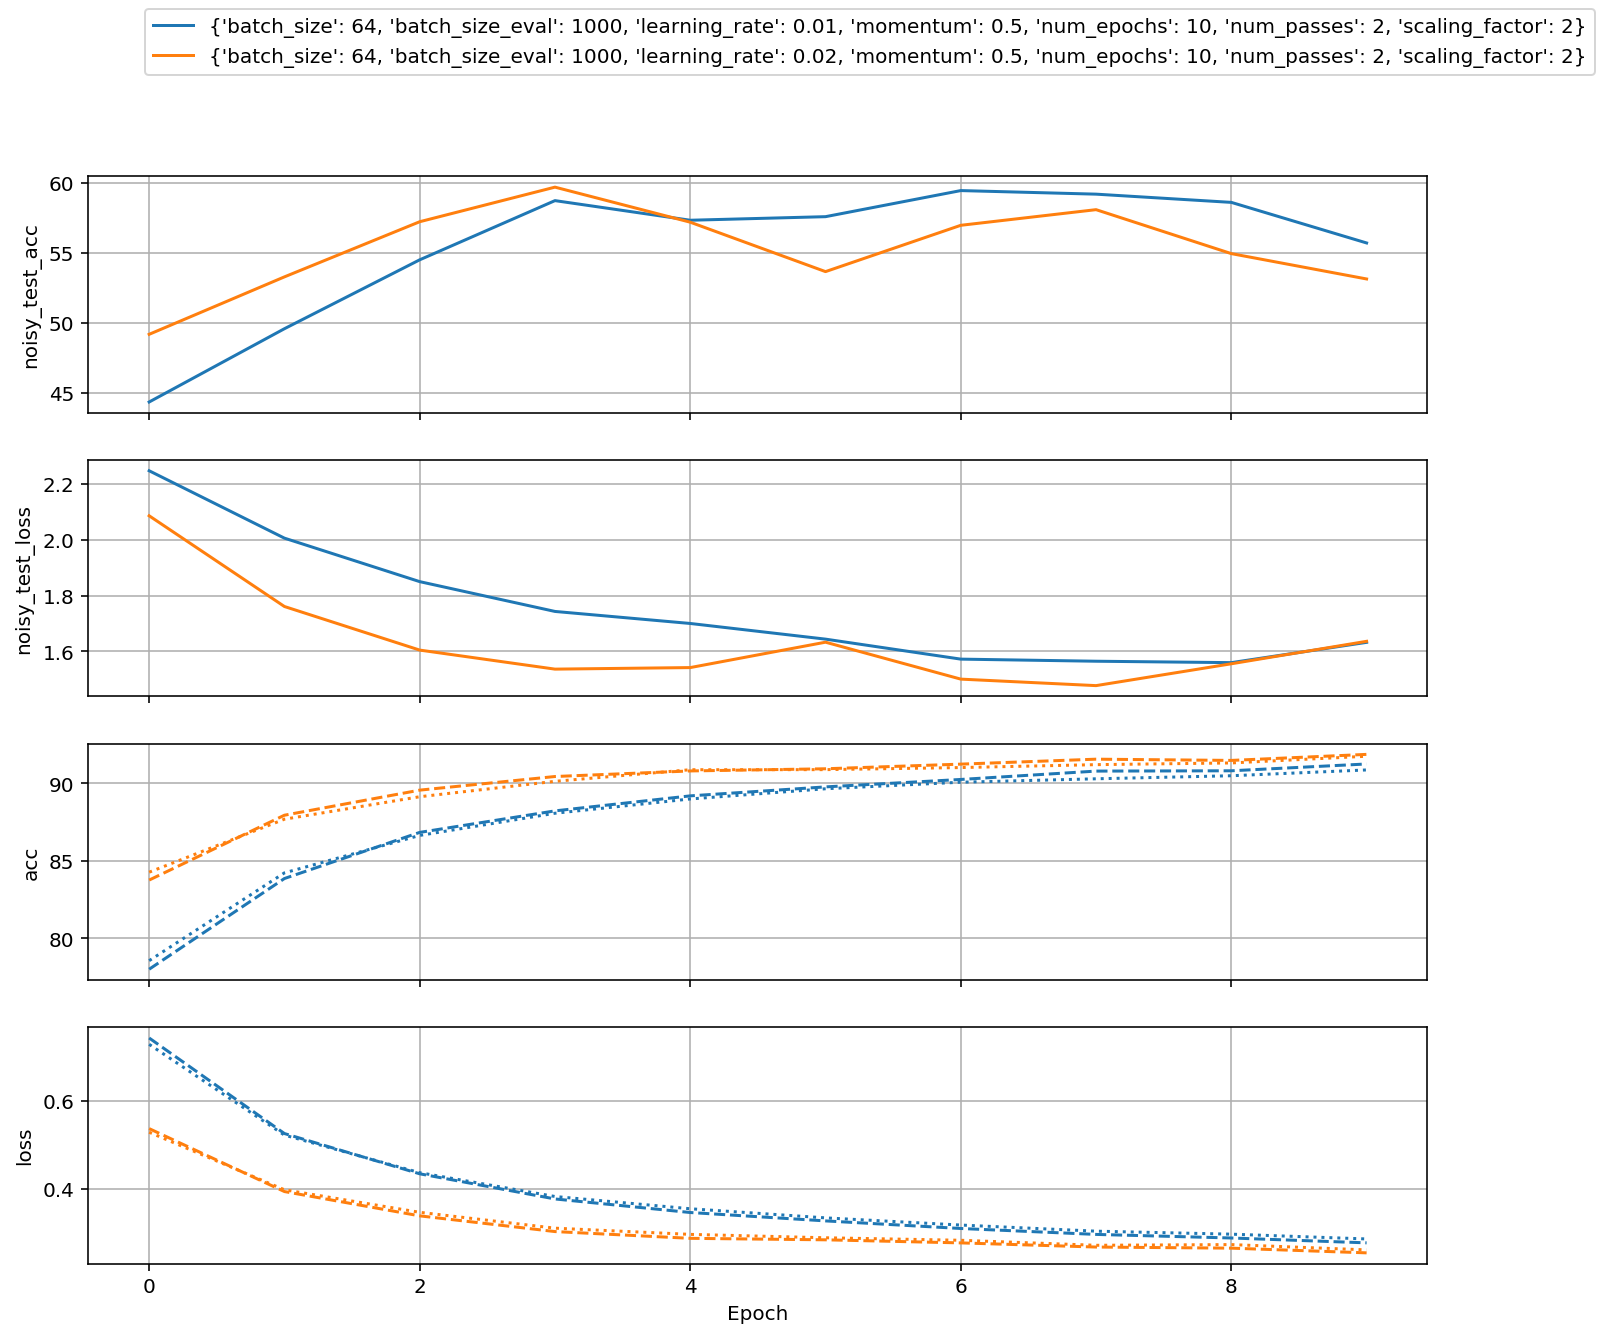

In [10]:
grid_search.plot(figsize=(12, 10))

# Experiment 2: Sequential Image Classification

In [15]:
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Make sequential dataset from EMNIST

In [8]:
def to_letter(index):
    return 'abcdefghijklmnopqrstuvwxyz'[index]

def to_index(letter):
    return ord(letter) - 97

In [9]:
num_allowed_seqs = 50
seq_len = 5
num_classes = 26  # mnist: 10, emnist: 26

#allowed_seqs = np.random.randint(0, num_classes, (num_allowed_seqs, seq_len))

In [10]:
allowed_seqs_letters = np.loadtxt('data/5-letter-words.txt', dtype=str)
np.random.seed(0)  # seed here so we choose the same words in each run
allowed_seqs_letters = np.random.choice(allowed_seqs_letters, num_allowed_seqs)
allowed_seqs = np.array([list(map(to_index, word)) for word in allowed_seqs_letters])

In [11]:
allowed_seqs[:10], allowed_seqs_letters[:10]

(array([[ 5, 14, 17, 20, 12],
        [ 1,  4,  6,  8, 13],
        [ 3,  0, 19,  4,  3],
        [ 6, 17,  4,  0, 19],
        [17,  0,  8, 18,  4],
        [12,  0, 17,  8,  0],
        [ 6, 17, 14, 20, 15],
        [18,  7, 14, 17, 19],
        [ 0,  6,  0,  8, 13],
        [ 8,  3,  4,  0, 11]]),
 array(['forum', 'begin', 'dated', 'great', 'raise', 'maria', 'group',
        'short', 'again', 'ideal'], dtype='<U5'))

In [12]:
np.unique(allowed_seqs, return_counts=True)
# TODO: Some letters appear very rarely in these words, gotta keep this in mind when training only on sequences. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 17, 18,
        19, 20, 21, 22, 24, 25]),
 array([20,  4,  8,  8, 32,  6,  7,  9, 18,  2,  8,  6, 11, 22,  6, 34, 14,
        19,  6,  2,  5,  2,  1]))

In [13]:
random_seqs = np.random.randint(0, num_classes, (num_allowed_seqs, seq_len))
random_seqs[:10]

array([[ 1,  9, 25,  0, 10],
       [20, 23,  3, 11, 18],
       [23,  2,  0,  0,  4],
       [21,  5,  6,  8, 20],
       [17, 15,  4,  9, 10],
       [24,  1,  1,  7,  9],
       [25,  3,  6, 23, 11],
       [14, 18,  0, 14,  3],
       [21, 12, 25, 10, 20],
       [11,  4,  6,  4, 15]])

In [16]:
train_dataset, val_dataset, test_dataset = datasets.load_emnist()
noisy_test_dataset = datasets.load_noisy_emnist(scaling_factor=4)

seq_train_dataset = datasets.ImageSequenceDataset(allowed_seqs, train_dataset, num_classes, num_samples=50000)
seq_test_dataset = datasets.ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000)
noisy_seq_test_dataset = datasets.ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000, 
                                                       noisy_image_dataset=noisy_test_dataset)
random_seq_test_dataset = datasets.ImageSequenceDataset(random_seqs, test_dataset, num_classes, num_samples=10000)
noisy_random_seq_test_dataset = datasets.ImageSequenceDataset(random_seqs, test_dataset, num_classes, 
                                                              num_samples=10000, 
                                                              noisy_image_dataset=noisy_test_dataset)

kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
seq_train_loader = torch.utils.data.DataLoader(seq_train_dataset, batch_size=params['batch_size'], 
                                               shuffle=True, **kwargs)
seq_test_loader = torch.utils.data.DataLoader(seq_test_dataset, batch_size=params['batch_size_eval'], 
                                              shuffle=False, **kwargs)
noisy_seq_test_loader = torch.utils.data.DataLoader(noisy_seq_test_dataset, batch_size=params['batch_size_eval'], 
                                                    shuffle=False, **kwargs)
random_seq_test_loader = torch.utils.data.DataLoader(random_seq_test_dataset, batch_size=params['batch_size_eval'], 
                                                     shuffle=False, **kwargs)
noisy_random_seq_test_loader = torch.utils.data.DataLoader(noisy_random_seq_test_dataset, 
                                                           batch_size=params['batch_size_eval'], 
                                                           shuffle=False, **kwargs)

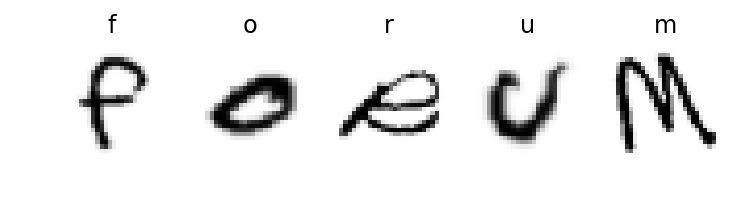

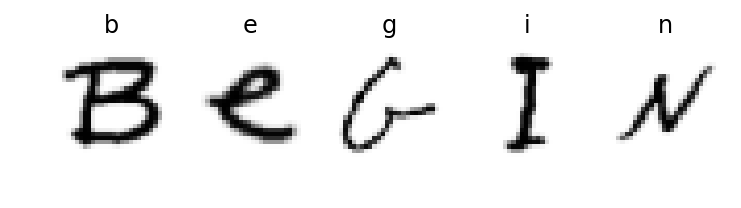

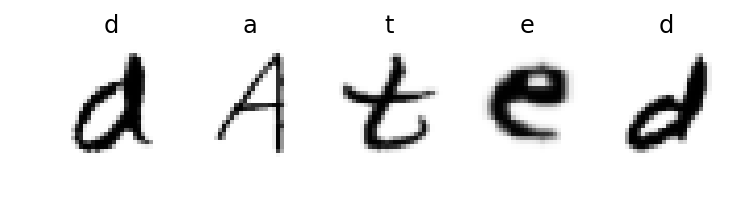

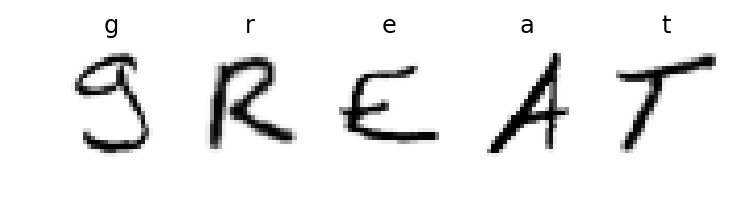

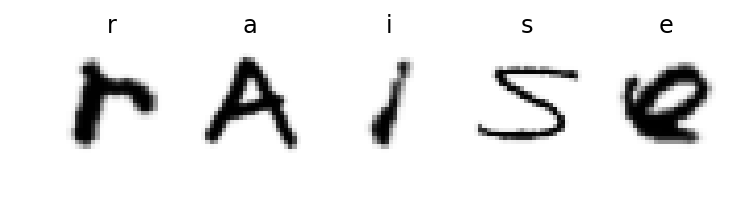

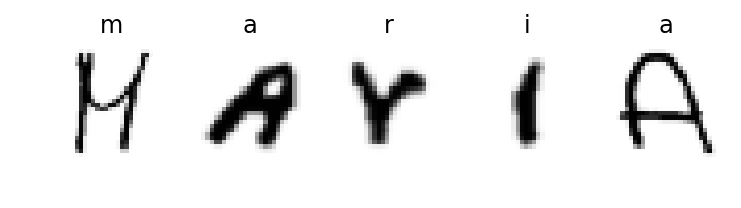

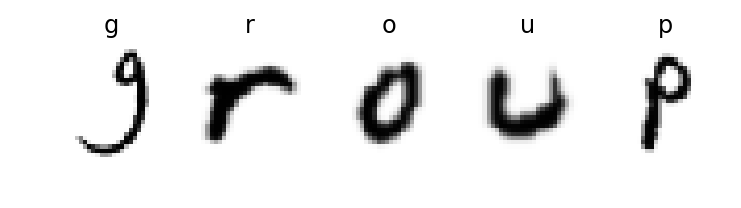

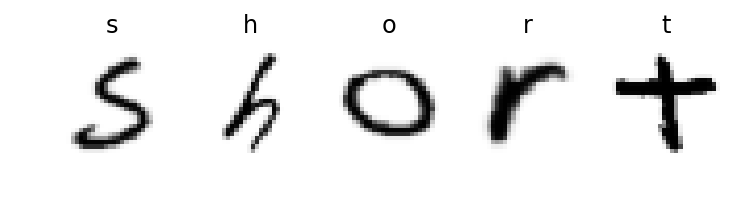

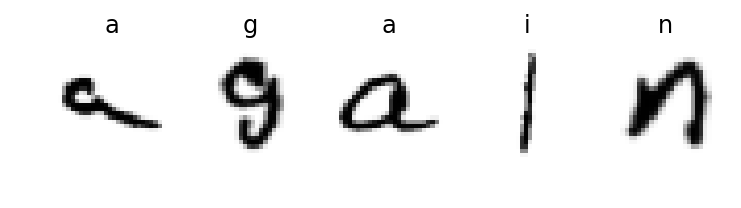

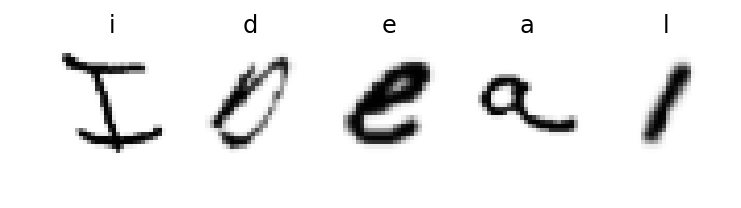

In [17]:
for i in range(10):
    plt.figure()
    datasets.plot_sequence(*seq_test_dataset[i], target_transform=to_letter)

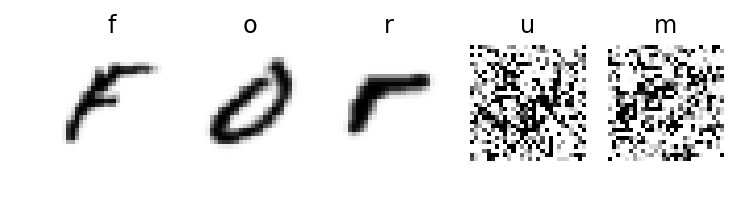

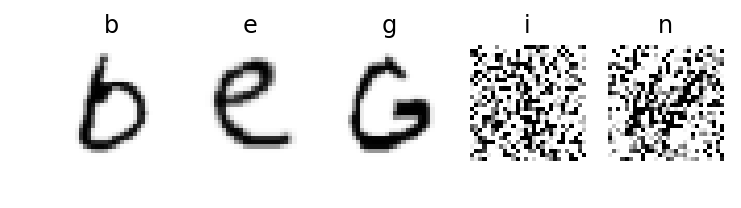

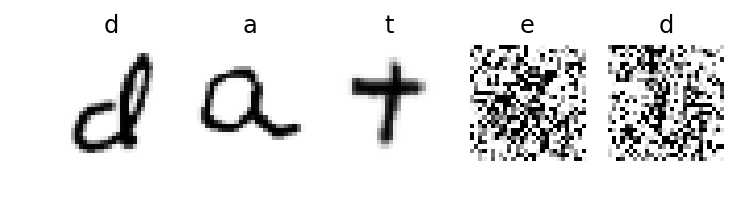

In [76]:
for i in range(3):
    plt.figure()
    datasets.plot_sequence(*noisy_seq_test_dataset[i], target_transform=to_letter)

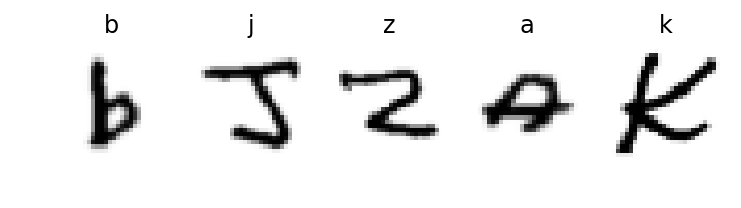

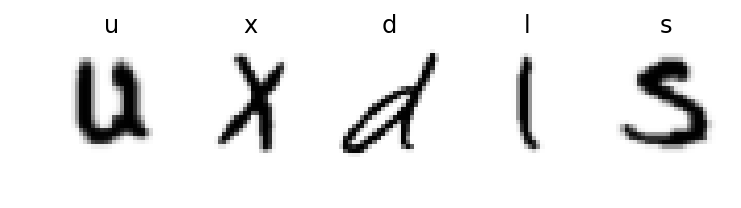

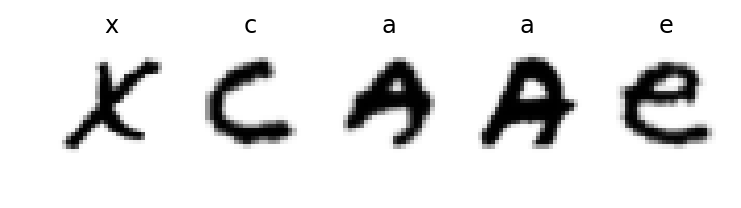

In [77]:
for i in range(3):
    plt.figure()
    datasets.plot_sequence(*random_seq_test_dataset[i], target_transform=to_letter)

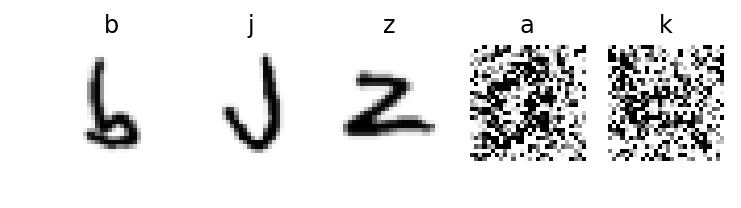

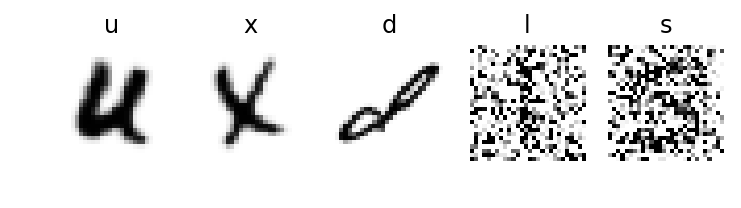

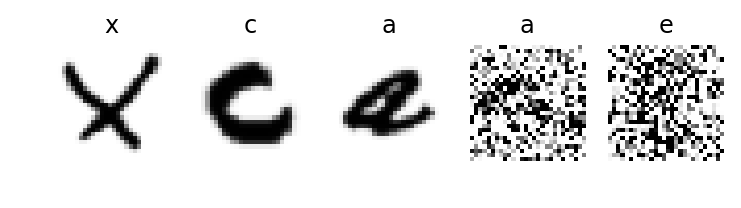

In [78]:
for i in range(3):
    plt.figure()
    datasets.plot_sequence(*noisy_random_seq_test_dataset[i], target_transform=to_letter)

## Networks

In [83]:
class SequentialLSTM(nn.Module):
    def __init__(self, num_hidden=500):
        super(SequentialLSTM, self).__init__()
        # TODO: Maybe change everything to batch_second.
        self.lstm1 = nn.LSTM(784, num_hidden, batch_first=True)
        self.lstm2 = nn.LSTM(num_hidden, 10, batch_first=True)
        
    def forward(self, inp):
        inp = inp.view(inp.shape[0], inp.shape[1], 784)
        #print(inp.shape)
        x, (hidden, cell) = self.lstm1(inp)
        # TODO: Need to add a non-linearity here?
        x, (hidden, cell) = self.lstm2(x)
        #print(x.shape, hidden.shape, cell.shape)
        #print(x.shape)
        x = F.log_softmax(x, dim=2)
        #print(x.sum(dim=(2)))
        return x

In [84]:
class SequentialFeedforwardNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(SequentialFeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            x = F.relu(self.forward1(x))
            x = self.dropout(x)
            x = F.log_softmax(self.forward2(x), dim=1)
            outp[:, i] = x
            
        return outp

In [102]:
class SequentialFeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5, alpha=0.5):
        super(SequentialFeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        #self.forward2 = nn.Linear(num_hidden, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        #self.feedback2 = nn.Linear(num_hidden, num_hidden)
        self.alpha = alpha
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp, plot_feedback=False):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        feedback_activation_1 = torch.zeros(inp.shape[0], self.forward1.weight.shape[1])
        #feedback_activation_2 = torch.zeros(inp.shape[0], self.forward2.weight.shape[1])
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            
            # 1st layer.
            if plot_feedback:
                plt.figure()
                plt.imshow(feedback_activation_1[0].detach().numpy().reshape(28, 28), cmap='Greys')
            x = F.relu(self.forward1((1 - self.alpha) * x + self.alpha * feedback_activation_1))
            feedback_activation_1 = self.feedback1(x)  # for next forward pass
            
            # 2nd layer.
            #x = F.relu(self.forward2((1 - self.alpha) * x + self.alpha * feedback_activation_2))
            #feedback_activation_2 = self.feedback2(x)
            
            # 3rd (readout) layer.
            x = self.dropout(x)
            x = F.log_softmax(self.forward2(x), dim=1)
            
            outp[:, i] = x
            
        return outp

In [54]:
imgs = seq_train_dataset[0][0]
model = SequentialFeedbackNet()
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()
model(imgs[None], no_feedback=False)

NameError: name 'ff_model' is not defined

## Training

In [63]:
# Good template for hyperparameter optimization:
#def run(train_dataset, val_dataset, device, params, history)
#def 

In [121]:
# TODO: Debug properly.
def train_sequential(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(seq_train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        #print(output.shape, target.shape)
        
        # TODO: According to https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
        #       need to do model.zero_grad() and model.hidden = model.init_hidden() here. 

        loss = F.nll_loss(output.transpose(1, 2), target)  # loss function requires transpose
        pred = output.view(-1, output.shape[-1]).max(1, keepdim=True)[1].view_as(target)  # get the index of the max log-probability
        correct = (pred == target).sum().item()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.1f} %'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item(), 100. * correct / (len(data) * seq_len)))

In [122]:
# TODO: Debug properly.
def test_sequential(model, device, test_loader, per_position=False, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    if per_position:
        correct_per_position = torch.zeros(seq_len)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.transpose(1, 2), target, reduction='sum').item() # sum up batch loss, loss function requires transpose
            
            pred = output.view(-1, output.shape[-1]).max(1, keepdim=True)[1].view_as(target) # get the index of the max log-probability
            correct += (pred == target).sum().item()
            if per_position:
                correct_per_position += (pred == target).float().sum(0)

    # TODO: Make this independent of seq_len (used twice!).
    test_loss /= len(test_loader.dataset) * seq_len
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f} %)'.format(
        test_loss, correct, len(test_loader.dataset) * seq_len,
        100. * correct / (len(test_loader.dataset) * seq_len)))
    if per_position:
        print('Accuracy per position:', ' | '.join(['{:.1f} %'.format(100. * corr.item() / len(test_loader.dataset)) for corr in correct_per_position]))

In [17]:
len([p for p in model.parameters() if p.requires_grad])

NameError: name 'model' is not defined

In [140]:
#model = SequentialFeedforwardNet().to(device)
model = SequentialFeedbackNet(dropout=0.5, alpha=0.5).to(device)

In [141]:
# Transfer feedforward parameters from model that was trained on EMNIST images (w/o sequences). 
trained_ff_model = torch.load('data/models/1_ff-model.pt')
model.forward1.weight.data = trained_ff_model.forward1.weight.data.clone()
model.forward1.bias.data = trained_ff_model.forward1.bias.data.clone()
model.forward2.weight.data = trained_ff_model.forward2.weight.data.clone()
model.forward2.bias.data = trained_ff_model.forward2.bias.data.clone()

In [142]:
test_sequential(model, device, seq_test_loader, per_position=True)
print()
print('Testing on noisy dataset:')
test_sequential(model, device, noisy_seq_test_loader, per_position=True)
print()
print('Testing on random words (without noise):')
test_sequential(model, device, random_seq_test_loader, per_position=True)
print()
print('Testing on random words (with noise):')
test_sequential(model, device, noisy_random_seq_test_loader, per_position=True)

Test set: Average loss: 0.4690, Accuracy: 45318/50000 (90.6 %)
Accuracy per position: 90.5 % | 91.4 % | 90.1 % | 89.1 % | 92.0 %

Testing on noisy dataset:
Test set: Average loss: 2.1940, Accuracy: 28957/50000 (57.9 %)
Accuracy per position: 90.8 % | 91.0 % | 89.9 % | 9.1 % | 8.8 %

Testing on random words (without noise):
Test set: Average loss: 0.4605, Accuracy: 45242/50000 (90.5 %)
Accuracy per position: 89.9 % | 92.0 % | 89.6 % | 89.2 % | 91.7 %

Testing on random words (with noise):
Test set: Average loss: 2.1866, Accuracy: 29227/50000 (58.5 %)
Accuracy per position: 89.9 % | 92.0 % | 89.8 % | 12.7 % | 7.8 %


In [144]:
model.forward1.weight.requires_grad = False
model.forward1.bias.requires_grad = False
model.forward2.weight.requires_grad = False
model.forward2.bias.requires_grad = False

In [145]:
#model = SequentialFeedforwardNet().to(device)
#model = SequentialLSTM().to(device)
#model = SequentialFeedbackNet(dropout=0.5, alpha=0.5).to(device)
# TODO: Use rmsprop or another optimizer which is good for LSTMs.
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=params['momentum'])
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.00001, momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train_sequential(model, device, seq_train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    
    print()
    test_sequential(model, device, seq_test_loader, per_position=True)
    print()
    print('Testing on noisy dataset:')
    test_sequential(model, device, noisy_seq_test_loader, per_position=True)
    print()
    print('Testing on random words (without noise):')
    test_sequential(model, device, random_seq_test_loader, per_position=True)
    print()
    print('Testing on random words (with noise):')
    test_sequential(model, device, noisy_random_seq_test_loader, per_position=True)
    print()
    print()

Epoch 1/30
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.245548	Accuracy: 91.2 %
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.182662	Accuracy: 94.4 %
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.182728	Accuracy: 95.0 %
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.216135	Accuracy: 95.0 %
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.173133	Accuracy: 95.3 %
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.178488	Accuracy: 95.0 %
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.158907	Accuracy: 95.9 %
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.269641	Accuracy: 92.5 %
Took 14.531431913375854 seconds

Test set: Average loss: 0.1682, Accuracy: 47777/50000 (95.6 %)
Accuracy per position: 91.8 % | 96.7 % | 96.8 % | 96.4 % | 96.0 %

Testing on noisy dataset:
Test set: Average loss: 3.6424, Accuracy: 35754/50000 (71.5 %)
Accuracy per position: 92.4 % | 97.0 % | 96.8 % | 41.1 % | 30.2 %

Testing on random words (without noise):
Test set: Average loss: 4.5120, Accuracy: 29375/50000 (58.8 %)
Accuracy per position: 68.0 % | 58.4

KeyboardInterrupt: 

In [136]:
#torch.save(model, 'data/models/fb_net.pt')

/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SequentialFeedbackNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [137]:
#torch.load('data/models/fb_net.pt')

SequentialFeedbackNet(
  (forward1): Linear(in_features=784, out_features=500, bias=True)
  (forward2): Linear(in_features=500, out_features=500, bias=True)
  (forward3): Linear(in_features=500, out_features=26, bias=True)
  (dropout): Dropout(p=0.5)
  (feedback1): Linear(in_features=500, out_features=784, bias=True)
  (feedback2): Linear(in_features=500, out_features=500, bias=True)
)

In [138]:
print('Testing on random words (without noise):')
test_sequential(model, device, random_seq_test_loader, per_position=True)
print()
print('Testing on random words (with noise):')
test_sequential(model, device, noisy_random_seq_test_loader, per_position=True)

Testing on random words (without noise):
Test set: Average loss: 0.4670, Accuracy: 45167/50000 (90.3 %)
Accuracy per position: 89.2 % | 92.3 % | 89.6 % | 89.5 % | 91.1 %

Testing on random words (with noise):
Test set: Average loss: 2.2322, Accuracy: 29116/50000 (58.2 %)
Accuracy per position: 89.1 % | 91.9 % | 89.4 % | 12.9 % | 7.9 %


In [140]:
test_sequential(model, device, seq_test_loader, per_position=True)

Test set: Average loss: 0.4314, Accuracy: 44944/50000 (89.9 %)
Accuracy per position: 86.1 % | 90.6 % | 93.0 % | 91.6 % | 88.1 %


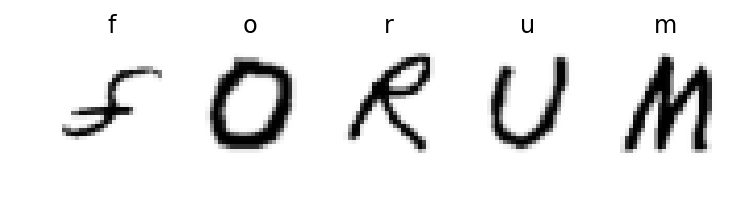

In [36]:
seq, target = seq_test_dataset[0]
datasets.plot_sequence(seq, target, target_transform=to_letter)

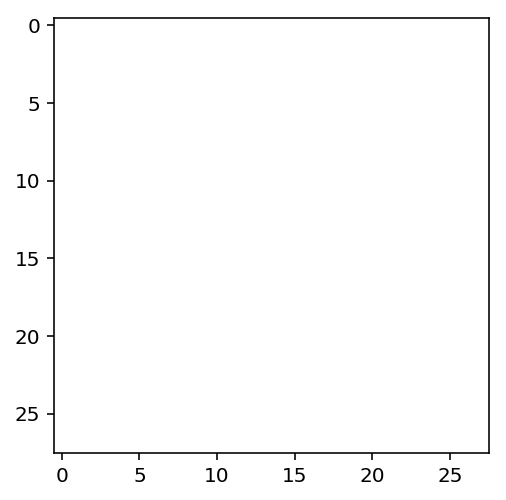

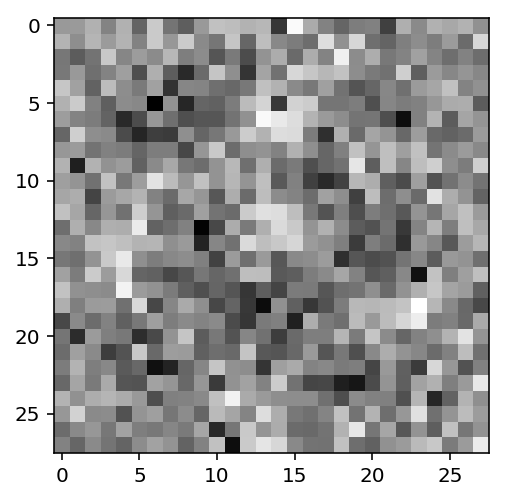

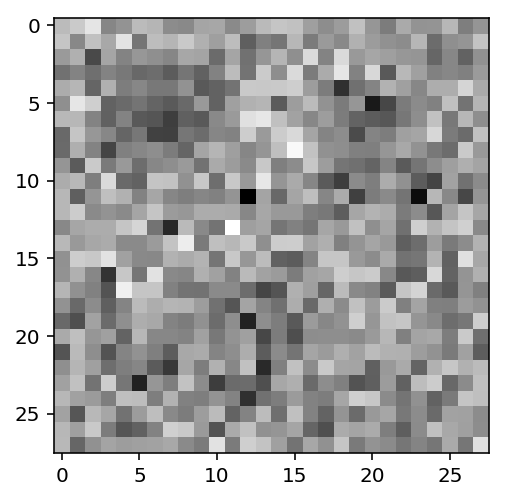

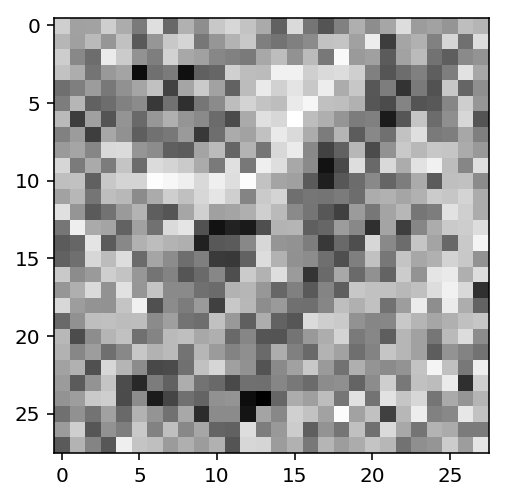

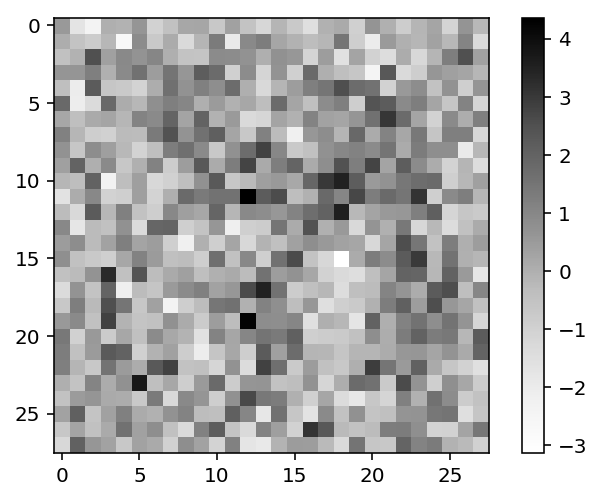

In [37]:
model(seq[None], plot_feedback=True);
plt.colorbar()

In [75]:
%debug

> <ipython-input-72-f941c31d9610>(28)forward()
     26             if plot_feedback:
     27                 plt.figure()
---> 28                 plt.imshow(feedback_activation_1[0].detach().numpy().view(28, 28), cmap='Greys')
     29             x = F.relu(self.forward1((1 - self.alpha) * x + self.alpha * feedback_activation_1))
     30             feedback_activation_1 = self.feedback1(x)  # for next forward pass

ipdb> feedback_activation_1[0].detach().numpy()
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

ipdb> q


In [236]:
model = SequentialFeedbackNet(dropout=0, alpha=0.5).to(device)

In [237]:
model.forward1.weight.data = ff_model.forward1.weight.data.clone()
model.forward1.bias.data = ff_model.forward1.bias.data.clone()
model.forward2.weight.data = ff_model.forward2.weight.data.clone()
model.forward2.bias.data = ff_model.forward2.bias.data.clone()

In [242]:
test_sequential(model, device, seq_test_loader, params)


Test set: Average loss: 0.5467, Accuracy: 46727/10000 (93%)



In [126]:
model.forward1.weight.requires_grad = False
model.forward1.bias.requires_grad = False
model.forward2.weight.requires_grad = False
model.forward2.bias.requires_grad = False


Test set: Average loss: 0.5414, Accuracy: 46792/10000 (94%)



In [86]:
#ff_model = model

In [239]:
test(ff_model, device, test_loader, params)


Test set: Average loss: 0.1806, Accuracy: 9459/10000 (95%)

